# Code

## Statistical Analysis

### Import the libraries

In [1]:
#install conda packages if they have not been run
#!conda install -c conda-forge lxml
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge folium=0.5.0 --yes

In [2]:
import pandas as pd
import numpy as np
import folium

#import geocoder libraries
from geopy.geocoders import Nominatim
from IPython.display import Image
from IPython.core.display import HTML

#import .json libraries
import json
from pandas.io.json import json_normalize
import requests

#import visualization libraries
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#import machine learning libraries
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [3]:
#Foursquared Credentials
CLIENT_ID = 'FQBYT13ZD21NGVPZ22FXVVEKOEZBLBT02KJC0D1R4HT10SKH'
CLIENT_SECRET = 'PMDHKUUT5C32UJKBQLKWT5EX50SKCT2LBO5DVJZ240SSTRGK'
VERSION = '20180604'
radius = 500
LIMIT = 100

In [4]:
#Toronto and New York Coordinates
torLat = 43.6532
torLong = -79.3832

nyLat = 40.7128
nyLong = -74.060

### Import the datasets

Please note that the raw datasets extracted from the .json file and online source for the neighborhoods in Toronto and Manhattan have previously been cleaned to remove rows  with NULLs.

In [5]:
#import the datasets
df_newyork = pd.read_csv('https://raw.githubusercontent.com/andrew940524/IBM/master/new%20york%20neighborhoods.csv')
df_toronto = pd.read_csv('https://raw.githubusercontent.com/andrew940524/IBM/master/Toronto_Neighborhoods.csv')

In [6]:
#clean the datasets to get rid of the unwanted data
df_newyork.drop(['Unnamed: 0', 'Borough'], axis=1, inplace=True)
df_toronto.drop(['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE',
       'AREA_LONG_CODE', 'AREA_DESC', 'X', 'Y', 'OBJECTID', 'Shape__Area', 'Shape__Length', 'geometry'], axis=1, inplace=True)

In [7]:
df_toronto.rename(columns={'AREA_NAME':'Neighborhood','LONGITUDE':'Longitude','LATITUDE':'Latitude'}, inplace=True)
df_toronto

,Neighborhood,Longitude,Latitude
0,Wychwood (94),-79.425515,43.676919
1,Yonge-Eglinton (100),-79.403590,43.704689
2,Yonge-St.Clair (97),-79.397871,43.687859
3,York University Heights (27),-79.488883,43.765736
4,Yorkdale-Glen Park (31),-79.457108,43.714672
...,...,...,...
135,Kennedy Park (124),-79.260382,43.725556
136,Kensington-Chinatown (78),-79.397240,43.653554
137,Kingsview Village-The Westway (6),-79.547863,43.698993
138,Kingsway South (15),-79.510577,43.653520


### Neighborhood Analysis

In [8]:
df_newyork.shape

(306, 3)

In [9]:
df_toronto.shape

(140, 3)

In [10]:
#create the function that extracts the most trendy venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
# run the getNearbyVenues to get the venue data for each city
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Wychwood (94)
Yonge-Eglinton (100)
Yonge-St.Clair (97)
York University Heights (27)
Yorkdale-Glen Park (31)
Lambton Baby Point (114)
Lansing-Westgate (38)
Lawrence Park North (105)
Lawrence Park South (103)
Leaside-Bennington (56)
Little Portugal (84)
Long Branch (19)
Malvern (132)
Maple Leaf (29)
Markland Wood (12)
Milliken (130)
Mimico (includes Humber Bay Shores) (17)
Morningside (135)
Moss Park (73)
Mount Dennis (115)
Mount Olive-Silverstone-Jamestown (2)
Mount Pleasant East (99)
Mount Pleasant West (104)
New Toronto (18)
Newtonbrook East (50)
Newtonbrook West (36)
Niagara (82)
North Riverdale (68)
North St.James Town (74)
O'Connor-Parkview (54)
Oakridge (121)
Oakwood Village (107)
Old East York (58)
Palmerston-Little Italy (80)
Parkwoods-Donalda (45)
Pelmo Park-Humberlea (23)
Playter Estates-Danforth (67)
Pleasant View (46)
Princess-Rosethorn (10)
Regent Park (72)
Rexdale-Kipling (4)
Rockcliffe-Smythe (111)
Roncesvalles (86)
Rosedale-Moore Park (98)
Rouge (131)
Runnymede-Bloor Wes

In [12]:
newyork_venues = getNearbyVenues(names=df_newyork['Neighborhood'],
                                   latitudes=df_newyork['Latitude'],
                                   longitudes=df_newyork['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

#### Summarize the venue data of each city

In [13]:
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wychwood (94),43.676919,-79.425515,Wychwood Barns,43.680028,-79.423810,Event Space
1,Wychwood (94),43.676919,-79.425515,Wychwood Barns Farmers' Market,43.680010,-79.423849,Farmers Market
2,Wychwood (94),43.676919,-79.425515,Hillcrest Park,43.676012,-79.424787,Park
3,Yonge-Eglinton (100),43.704689,-79.403590,North Toronto Memorial Community Centre,43.706098,-79.404337,Gym
4,Yonge-Eglinton (100),43.704689,-79.403590,Burger Shack,43.704855,-79.406067,Burger Joint
...,...,...,...,...,...,...,...
2035,L'Amoreaux (117),43.795716,-79.314084,Dollarama,43.798394,-79.318453,Discount Store
2036,L'Amoreaux (117),43.795716,-79.314084,Olympian Swimming,43.791575,-79.313204,Gym Pool
2037,L'Amoreaux (117),43.795716,-79.314084,Dumpling & Szechuan Cuisine（川流不息店）,43.791567,-79.312900,Chinese Restaurant
2038,L'Amoreaux (117),43.795716,-79.314084,Ocean Nails Spa,43.795290,-79.320101,Nail Salon


In [14]:
newyork_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
...,...,...,...,...,...,...,...
9774,Fox Hills,40.617311,-74.081740,Mona's Cuisine,40.618282,-74.084975,African Restaurant
9775,Fox Hills,40.617311,-74.081740,Bums Chicken N Ribs Joint,40.618192,-74.085506,BBQ Joint
9776,Fox Hills,40.617311,-74.081740,Bums Pancake N Waffle Grill,40.618287,-74.085525,American Restaurant
9777,Fox Hills,40.617311,-74.081740,Stop 1 Supermarket,40.614576,-74.084714,Grocery Store


In [15]:
# concatnate the venue data of each city into one dataframe
frames = (newyork_venues, toronto_venues)
neighborhood_venues = pd.concat(frames)
neighborhood_venues.sort_values('Neighborhood').reset_index(drop=True, inplace=True)
neighborhood_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
...,...,...,...,...,...,...,...
2035,L'Amoreaux (117),43.795716,-79.314084,Dollarama,43.798394,-79.318453,Discount Store
2036,L'Amoreaux (117),43.795716,-79.314084,Olympian Swimming,43.791575,-79.313204,Gym Pool
2037,L'Amoreaux (117),43.795716,-79.314084,Dumpling & Szechuan Cuisine（川流不息店）,43.791567,-79.312900,Chinese Restaurant
2038,L'Amoreaux (117),43.795716,-79.314084,Ocean Nails Spa,43.795290,-79.320101,Nail Salon


In [16]:
# create  a new dataframe that only shows the type of venue and the number of said venue
newyork_summary = newyork_venues.groupby('Venue Category').count()[['Venue']]
toronto_summary = toronto_venues.groupby('Venue Category').count()[['Venue']]

In [17]:
#find the total number of venues for percentage calculation
totalTorontoVenue = toronto_summary['Venue'].sum()
totalNewyorkVenue = newyork_summary['Venue'].sum()

In [18]:
#define function that finds the top 20 most numerous venues in the cities
def findTop(dataframe):
    dataframe.sort_values(by='Venue', ascending=False, inplace=True)
    return dataframe.head(20)

In [19]:
torTop = findTop(dataframe = toronto_summary)
nyTop = findTop(dataframe = newyork_summary)

In [20]:
# calculate the percentage of each venue category
torTop['Percentage'] = toronto_summary['Venue']/totalTorontoVenue
nyTop['Percentage'] = newyork_summary['Venue']/totalNewyorkVenue

C:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
torTop

,Venue,Percentage
Venue Category,,
Coffee Shop,153,0.075000
Park,81,0.039706
Café,81,0.039706
Pizza Place,69,0.033824
Sandwich Place,60,0.029412
Italian Restaurant,55,0.026961
Restaurant,51,0.025000
Bar,42,0.020588
Grocery Store,42,0.020588


In [22]:
nyTop

,Venue,Percentage
Venue Category,,
Pizza Place,435,0.044483
Italian Restaurant,298,0.030473
Coffee Shop,288,0.029451
Deli / Bodega,261,0.026690
Chinese Restaurant,222,0.022702
Bakery,215,0.021986
Bar,195,0.019941
Grocery Store,194,0.019838
Sandwich Place,184,0.018816


In [23]:
# create a new dataframe that summarize all the numbers
overlap = torTop.merge(nyTop, left_index=True, right_index=True)
overlap = overlap.rename(columns={'key_0':'Venue Category', 
                          'Venue_x':'Toronto Venues', 
                          'Percentage_x':'Toronto Percentages', 
                          'Venue_y':'New York Venues', 
                          'Percentage_y':'New York Percentages'})
overlap['Venue Total'] = overlap['Toronto Venues'] + overlap['New York Venues']
overlap

,Toronto Venues,Toronto Percentages,New York Venues,New York Percentages,Venue Total
Venue Category,,,,,
Coffee Shop,153,0.075000,288,0.029451,441
Park,81,0.039706,180,0.018407,261
Café,81,0.039706,166,0.016975,247
Pizza Place,69,0.033824,435,0.044483,504
Sandwich Place,60,0.029412,184,0.018816,244
Italian Restaurant,55,0.026961,298,0.030473,353
Bar,42,0.020588,195,0.019941,237
Grocery Store,42,0.020588,194,0.019838,236
Bakery,39,0.019118,215,0.021986,254


<Figure size 3600x720 with 0 Axes>

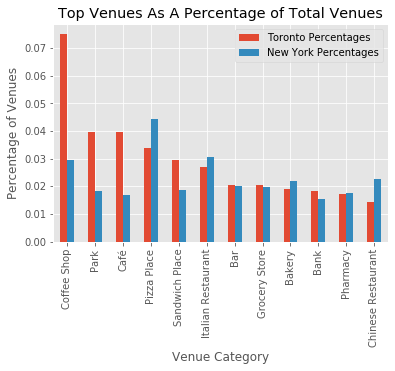

In [24]:
# plot the percentage of top venues that were in both Toronto and New York

plt.style.use('ggplot')

fig = plt.figure(figsize=(50,10))

ax = overlap[['Toronto Percentages', 'New York Percentages']].plot(kind='bar')

plt.title('Top Venues As A Percentage of Total Venues')
plt.xlabel('Venue Category')
plt.ylabel('Percentage of Venues')
ax.set_xticklabels(overlap.index)

plt.legend()
plt.show()

<Figure size 3600x720 with 0 Axes>

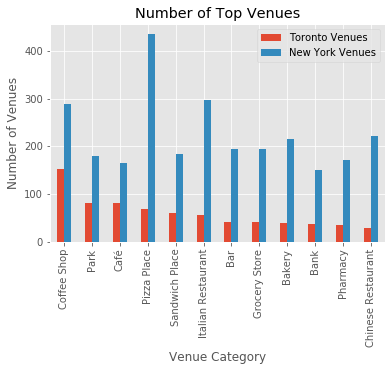

In [25]:
#plot the bar chart showing the absolute number of venues

fig = plt.figure(figsize=(50,10))

ax = overlap[['Toronto Venues', 'New York Venues']].plot(kind='bar')

plt.title('Number of Top Venues')
plt.xlabel('Venue Category')
plt.ylabel('Number of Venues')
ax.set_xticklabels(overlap.index)

plt.legend()
plt.show()

#### Identify the top venues in each neighborhood

In [26]:
#onehot encode the cities to get the venues
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

#add the neighborhood columns back into the onehot encoded dataframes
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood']
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

In [27]:
newyork_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
...,...,...,...,...,...,...,...
9774,Fox Hills,40.617311,-74.081740,Mona's Cuisine,40.618282,-74.084975,African Restaurant
9775,Fox Hills,40.617311,-74.081740,Bums Chicken N Ribs Joint,40.618192,-74.085506,BBQ Joint
9776,Fox Hills,40.617311,-74.081740,Bums Pancake N Waffle Grill,40.618287,-74.085525,American Restaurant
9777,Fox Hills,40.617311,-74.081740,Stop 1 Supermarket,40.614576,-74.084714,Grocery Store


In [28]:
#Calculate the frequencies of venues in each neighborhood in Toronto and New York
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [29]:
newyork_grouped.shape

(300, 426)

In [30]:
toronto_grouped.shape

(137, 275)

In [31]:
# concatnate the two dataframes for machine learning clustering

frames = (newyork_grouped, toronto_grouped)
neighborhood_grouped = pd.concat(frames)
neighborhood_grouped.reset_index(drop=True, inplace=True)
neighborhood_grouped = neighborhood_grouped.fillna(0)
neighborhood_grouped.sort_values('Neighborhood')
neighborhood_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,...,Pastry Shop,Portuguese Restaurant,Poutine Place,Rock Climbing Spot,Science Museum,Syrian Restaurant,Tram Station,Transportation Service,Zoo,Zoo Exhibit
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,Wychwood (94),0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433,Yonge-Eglinton (100),0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434,Yonge-St.Clair (97),0.0,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
435,York University Heights (27),0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#Sort the venues in descenind order
num_top_venues = 10

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
# create loops that willl identify the top 10 most common venues in each neighborhood and place them in columns

num_top_venues = 10
columns = ['Neighborhood']

indicators = ['st', 'nd', 'rd']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
ny_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
ny_neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    ny_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

In [34]:
ny_neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Martial Arts Dojo,Donut Shop,Breakfast Spot,Fried Chicken Joint,Spanish Restaurant,Bus Station
1,Annadale,Pub,Deli / Bodega,Train Station,Pizza Place,Diner,Sushi Restaurant,Restaurant,Park,Sports Bar,American Restaurant
2,Arden Heights,Pizza Place,Pharmacy,Smoke Shop,Pool,Coffee Shop,Yoga Studio,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
3,Arlington,Bus Stop,Deli / Bodega,American Restaurant,Boat or Ferry,Home Service,Yoga Studio,Filipino Restaurant,Event Space,Exhibit,Eye Doctor
4,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Sporting Goods Shop,Pizza Place,Mediterranean Restaurant,Outdoors & Recreation,Middle Eastern Restaurant,Bagel Shop,Sandwich Place
...,...,...,...,...,...,...,...,...,...,...,...
295,Woodhaven,Deli / Bodega,Pharmacy,Bank,Pizza Place,Donut Shop,Bagel Shop,Latin American Restaurant,Metro Station,Park,Restaurant
296,Woodlawn,Pub,Pizza Place,Deli / Bodega,Food & Drink Shop,Playground,Italian Restaurant,Trail,Grocery Store,Park,Indian Restaurant
297,Woodrow,Pharmacy,Sushi Restaurant,Pizza Place,Grocery Store,Martial Arts Dojo,Mexican Restaurant,Miscellaneous Shop,Bank,Bakery,Liquor Store
298,Woodside,Grocery Store,Thai Restaurant,Bakery,Latin American Restaurant,Filipino Restaurant,Bar,Pub,American Restaurant,Donut Shop,Sandwich Place


In [35]:
num_top_venues = 10
columns = ['Neighborhood']

indicators = ['st', 'nd', 'rd']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
tor_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    tor_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

In [36]:
tor_neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North (129),Chinese Restaurant,Pizza Place,Clothing Store,Fast Food Restaurant,Liquor Store,Fried Chicken Joint,Frozen Yogurt Shop,Sandwich Place,Beer Store,Bakery
1,Agincourt South-Malvern West (128),Chinese Restaurant,Shopping Mall,Filipino Restaurant,Restaurant,Bank,Cantonese Restaurant,Noodle House,BBQ Joint,Asian Restaurant,Japanese Restaurant
2,Alderwood (20),Pizza Place,Convenience Store,Pharmacy,Coffee Shop,Fish Market,Fish & Chips Shop,Flea Market,Filipino Restaurant,Field,Dumpling Restaurant
3,Annex (95),Café,Sandwich Place,Park,Coffee Shop,Pub,Pharmacy,BBQ Joint,Social Club,Middle Eastern Restaurant,Cosmetics Shop
4,Banbury-Don Mills (42),Pizza Place,Gourmet Shop,Pharmacy,Cantonese Restaurant,Sandwich Place,Chocolate Shop,Bank,Italian Restaurant,Movie Theater,Clothing Store
...,...,...,...,...,...,...,...,...,...,...,...
132,Wychwood (94),Farmers Market,Park,Event Space,Farm,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Zoo Exhibit,Dumpling Restaurant
133,Yonge-Eglinton (100),Coffee Shop,Fast Food Restaurant,Plaza,Gym,Restaurant,Movie Theater,Poutine Place,Department Store,Deli / Bodega,Pizza Place
134,Yonge-St.Clair (97),Coffee Shop,Italian Restaurant,Sushi Restaurant,Sandwich Place,Bagel Shop,Gym,Grocery Store,Pub,Thai Restaurant,Restaurant
135,York University Heights (27),Bank,Coffee Shop,Massage Studio,Fast Food Restaurant,Caribbean Restaurant,Bar,Japanese Restaurant,Miscellaneous Shop,Dim Sum Restaurant,Dance Studio


In [59]:
# combine the two dataframes showing the top 10 most common venues in each neighborhood together

frames = (ny_neighborhoods_venues_sorted, tor_neighborhoods_venues_sorted)
neighborhoods_venues_sorted = pd.concat(frames)
neighborhoods_venues_sorted.sort_values('Neighborhood')
neighborhoods_venues_sorted.reset_index(drop=True, inplace=True)
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Martial Arts Dojo,Donut Shop,Breakfast Spot,Fried Chicken Joint,Spanish Restaurant,Bus Station
1,Annadale,Pub,Deli / Bodega,Train Station,Pizza Place,Diner,Sushi Restaurant,Restaurant,Park,Sports Bar,American Restaurant
2,Arden Heights,Pizza Place,Pharmacy,Smoke Shop,Pool,Coffee Shop,Yoga Studio,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
3,Arlington,Bus Stop,Deli / Bodega,American Restaurant,Boat or Ferry,Home Service,Yoga Studio,Filipino Restaurant,Event Space,Exhibit,Eye Doctor
4,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Sporting Goods Shop,Pizza Place,Mediterranean Restaurant,Outdoors & Recreation,Middle Eastern Restaurant,Bagel Shop,Sandwich Place
...,...,...,...,...,...,...,...,...,...,...,...
432,Wychwood (94),Farmers Market,Park,Event Space,Farm,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Zoo Exhibit,Dumpling Restaurant
433,Yonge-Eglinton (100),Coffee Shop,Fast Food Restaurant,Plaza,Gym,Restaurant,Movie Theater,Poutine Place,Department Store,Deli / Bodega,Pizza Place
434,Yonge-St.Clair (97),Coffee Shop,Italian Restaurant,Sushi Restaurant,Sandwich Place,Bagel Shop,Gym,Grocery Store,Pub,Thai Restaurant,Restaurant
435,York University Heights (27),Bank,Coffee Shop,Massage Studio,Fast Food Restaurant,Caribbean Restaurant,Bar,Japanese Restaurant,Miscellaneous Shop,Dim Sum Restaurant,Dance Studio


## Machine Learning Algorithms

### K-Means

In [38]:
# identify the best number of K-Means to use 
average_distance = []
num_k = []

neighborhood_grouped_clustering = neighborhood_grouped.drop('Neighborhood',1)

for i in range(1, 10):
    k_means = KMeans(init='k-means++', n_clusters=i, random_state=0, n_init=20)
    k_means.fit(neighborhood_grouped_clustering)
    average_distance.append(k_means.inertia_)
    num_k.append(i)

In [39]:
neighborhood_grouped_clustering

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,...,Pastry Shop,Portuguese Restaurant,Poutine Place,Rock Climbing Spot,Science Museum,Syrian Restaurant,Tram Station,Transportation Service,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434,0.0,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
435,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Average Distance to Centroid')

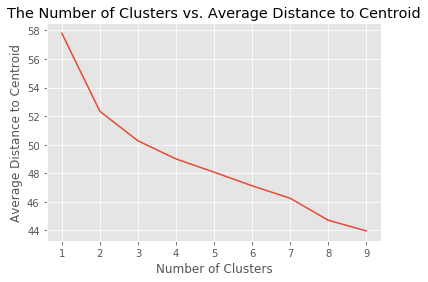

In [40]:
# plot the line graph between average distance and num_k to use the elbow method to find the optmial number of clusters
fig = plt.figure()
ax = plt.axes()

x = num_k
ax.plot(x, average_distance)
ax.set_title('The Number of Clusters vs. Average Distance to Centroid')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Average Distance to Centroid')

Using the "Elbow Method", it was determined the optimal number of clusters is two.

In [41]:
k_means = KMeans(init='k-means++', n_clusters=2, random_state=0, n_init=20).fit(neighborhood_grouped_clustering)
k_means.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [60]:
#create a dataframe which includes the cluster label
kmeansDataFrame = neighborhoods_venues_sorted
kmeansDataFrame.insert(0, 'Cluster Labels', k_means.labels_)

In [43]:
kMeansCluster1 = kmeansDataFrame.loc[kmeansDataFrame['Cluster Labels'] == 1]
kMeansCluster1.to_csv('kMeansCluster1.csv')

In [44]:
kMeansCluster1

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,1,Bayswater,Playground,Park,Yoga Studio,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
55,1,Clason Point,Park,South American Restaurant,Grocery Store,Pool,Boat or Ferry,Bus Stop,Yoga Studio,Event Space,Exhibit,Eye Doctor
222,1,Randall Manor,Park,Bus Stop,Bagel Shop,Yoga Studio,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
248,1,Somerville,Park,Yoga Studio,Entertainment Service,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
255,1,Spuyten Duyvil,Park,Intersection,Asian Restaurant,Tennis Stadium,Thai Restaurant,Pharmacy,Bank,Design Studio,Daycare,Dance Studio
267,1,Todt Hill,Park,Yoga Studio,Entertainment Service,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
305,1,Bathurst Manor (34),Convenience Store,Playground,Park,Baseball Field,Fish Market,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant,Eastern European Restaurant
308,1,Bayview Woods-Steeles (49),Park,Dog Run,Basketball Court,Zoo Exhibit,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm
311,1,Bendale (127),Park,Food Truck,History Museum,Greek Restaurant,Zoo Exhibit,Event Space,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant
318,1,Brookhaven-Amesbury (30),Park,Zoo Exhibit,Farm,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Dumpling Restaurant


In [45]:
neighborhood_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
...,...,...,...,...,...,...,...
2035,L'Amoreaux (117),43.795716,-79.314084,Dollarama,43.798394,-79.318453,Discount Store
2036,L'Amoreaux (117),43.795716,-79.314084,Olympian Swimming,43.791575,-79.313204,Gym Pool
2037,L'Amoreaux (117),43.795716,-79.314084,Dumpling & Szechuan Cuisine（川流不息店）,43.791567,-79.312900,Chinese Restaurant
2038,L'Amoreaux (117),43.795716,-79.314084,Ocean Nails Spa,43.795290,-79.320101,Nail Salon


In [46]:
#filter venues that are in cluster 1
filter1 = neighborhood_venues['Neighborhood'].isin(kMeansCluster1['Neighborhood'])
kmeansCluster1Count = neighborhood_venues[filter1].sort_values('Neighborhood')
kmeansCluster1Count

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1197,Bathurst Manor (34),43.764813,-79.456055,Wilmington Convenience And Produce,43.764925,-79.455086,Convenience Store
1200,Bathurst Manor (34),43.764813,-79.456055,Irving W. Chapley Community Centre & Park,43.761247,-79.455509,Park
1198,Bathurst Manor (34),43.764813,-79.456055,Chapley Baseball Park,43.762100,-79.455866,Baseball Field
1199,Bathurst Manor (34),43.764813,-79.456055,Wilmington Park,43.761534,-79.456091,Playground
9752,Bayswater,40.611322,-73.765968,Inwood Park,40.614236,-73.761475,Park
...,...,...,...,...,...,...,...
1084,Willowdale West (37),43.771210,-79.427558,Abbotsford Park,43.771191,-79.422450,Park
1085,Willowdale West (37),43.771210,-79.427558,Mobilicity,43.769937,-79.422369,Mobile Phone Shop
2,Wychwood (94),43.676919,-79.425515,Hillcrest Park,43.676012,-79.424787,Park
0,Wychwood (94),43.676919,-79.425515,Wychwood Barns,43.680028,-79.423810,Event Space


In [47]:
kmeansCluster1Count = kmeansCluster1Count.groupby('Venue Category').count()
kmeansCluster1Count.drop(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], axis=1, inplace=True)
kmeansCluster1Count = kmeansCluster1Count.sort_values('Venue', ascending=False)

In [48]:
kmeansCluster1Count

,Venue
Venue Category,
Park,43
Dog Run,3
Construction & Landscaping,3
Playground,3
Pool,3
Bus Stop,3
Mobile Phone Shop,2
Moving Target,2
Electronics Store,2


### DBSCAN

In [80]:
# initiate and begin the DBSCAN process.  The epsilon for the radius is set at 0.3, and the minimum number of samples to  be
# considered a cluser is set at 7.
db = DBSCAN(eps=0.3, min_samples=7).fit(neighborhood_grouped_clustering)
labels = db.labels_

In [81]:
# find the number of clusters.  If there are  any outliers, it is given the label of -1.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

1

In [82]:
#reset the neighborhoods_venues_sorted dataframe
frames = (ny_neighborhoods_venues_sorted, tor_neighborhoods_venues_sorted)
neighborhoods_venues_sorted = pd.concat(frames)
neighborhoods_venues_sorted.sort_values('Neighborhood')
neighborhoods_venues_sorted.reset_index(drop=True, inplace=True)
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Martial Arts Dojo,Donut Shop,Breakfast Spot,Fried Chicken Joint,Spanish Restaurant,Bus Station
1,Annadale,Pub,Deli / Bodega,Train Station,Pizza Place,Diner,Sushi Restaurant,Restaurant,Park,Sports Bar,American Restaurant
2,Arden Heights,Pizza Place,Pharmacy,Smoke Shop,Pool,Coffee Shop,Yoga Studio,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
3,Arlington,Bus Stop,Deli / Bodega,American Restaurant,Boat or Ferry,Home Service,Yoga Studio,Filipino Restaurant,Event Space,Exhibit,Eye Doctor
4,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Sporting Goods Shop,Pizza Place,Mediterranean Restaurant,Outdoors & Recreation,Middle Eastern Restaurant,Bagel Shop,Sandwich Place
...,...,...,...,...,...,...,...,...,...,...,...
432,Wychwood (94),Farmers Market,Park,Event Space,Farm,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Zoo Exhibit,Dumpling Restaurant
433,Yonge-Eglinton (100),Coffee Shop,Fast Food Restaurant,Plaza,Gym,Restaurant,Movie Theater,Poutine Place,Department Store,Deli / Bodega,Pizza Place
434,Yonge-St.Clair (97),Coffee Shop,Italian Restaurant,Sushi Restaurant,Sandwich Place,Bagel Shop,Gym,Grocery Store,Pub,Thai Restaurant,Restaurant
435,York University Heights (27),Bank,Coffee Shop,Massage Studio,Fast Food Restaurant,Caribbean Restaurant,Bar,Japanese Restaurant,Miscellaneous Shop,Dim Sum Restaurant,Dance Studio


In [83]:
DbscanDataFrame = neighborhoods_venues_sorted
DbscanDataFrame

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Martial Arts Dojo,Donut Shop,Breakfast Spot,Fried Chicken Joint,Spanish Restaurant,Bus Station
1,Annadale,Pub,Deli / Bodega,Train Station,Pizza Place,Diner,Sushi Restaurant,Restaurant,Park,Sports Bar,American Restaurant
2,Arden Heights,Pizza Place,Pharmacy,Smoke Shop,Pool,Coffee Shop,Yoga Studio,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
3,Arlington,Bus Stop,Deli / Bodega,American Restaurant,Boat or Ferry,Home Service,Yoga Studio,Filipino Restaurant,Event Space,Exhibit,Eye Doctor
4,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Sporting Goods Shop,Pizza Place,Mediterranean Restaurant,Outdoors & Recreation,Middle Eastern Restaurant,Bagel Shop,Sandwich Place
...,...,...,...,...,...,...,...,...,...,...,...
432,Wychwood (94),Farmers Market,Park,Event Space,Farm,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Zoo Exhibit,Dumpling Restaurant
433,Yonge-Eglinton (100),Coffee Shop,Fast Food Restaurant,Plaza,Gym,Restaurant,Movie Theater,Poutine Place,Department Store,Deli / Bodega,Pizza Place
434,Yonge-St.Clair (97),Coffee Shop,Italian Restaurant,Sushi Restaurant,Sandwich Place,Bagel Shop,Gym,Grocery Store,Pub,Thai Restaurant,Restaurant
435,York University Heights (27),Bank,Coffee Shop,Massage Studio,Fast Food Restaurant,Caribbean Restaurant,Bar,Japanese Restaurant,Miscellaneous Shop,Dim Sum Restaurant,Dance Studio


In [84]:
DbscanDataFrame.insert(0, 'Cluster Labels', db.labels_)

In [85]:
DbscanDataFrame['Cluster Labels'].values

array([ 0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0, -1, -1,  0, -1, -1,
        0,  0, -1,  0,  0,  0, -1, -1, -1,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0, -1,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0, -1, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,
        0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0, -1, -1,  0,  0,
        0, -1,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0, -1,
       -1,  0,  0,  0,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0

#### DBSCAN Cluster 0 Summary

In [86]:
dbscanCluster0 = dbscanCluster1 = DbscanDataFrame.loc[DbscanDataFrame['Cluster Labels']==0]
dbscanCluster0

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Martial Arts Dojo,Donut Shop,Breakfast Spot,Fried Chicken Joint,Spanish Restaurant,Bus Station
1,0,Annadale,Pub,Deli / Bodega,Train Station,Pizza Place,Diner,Sushi Restaurant,Restaurant,Park,Sports Bar,American Restaurant
4,0,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Sporting Goods Shop,Pizza Place,Mediterranean Restaurant,Outdoors & Recreation,Middle Eastern Restaurant,Bagel Shop,Sandwich Place
6,0,Astoria,Middle Eastern Restaurant,Bar,Mediterranean Restaurant,Hookah Bar,Greek Restaurant,Pizza Place,Bakery,Seafood Restaurant,Indian Restaurant,Café
7,0,Astoria Heights,Italian Restaurant,Playground,Burger Joint,Shopping Mall,Cocktail Bar,Supermarket,Bus Station,Plaza,Bowling Alley,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...,...
424,0,Weston (113),Coffee Shop,Train Station,Convenience Store,Bank,Discount Store,Diner,Fried Chicken Joint,Sandwich Place,Soccer Field,Pharmacy
426,0,Wexford/Maryvale (119),Burger Joint,Pizza Place,Vietnamese Restaurant,Bar,Intersection,Coffee Shop,Korean Restaurant,Breakfast Spot,Middle Eastern Restaurant,Pharmacy
433,0,Yonge-Eglinton (100),Coffee Shop,Fast Food Restaurant,Plaza,Gym,Restaurant,Movie Theater,Poutine Place,Department Store,Deli / Bodega,Pizza Place
434,0,Yonge-St.Clair (97),Coffee Shop,Italian Restaurant,Sushi Restaurant,Sandwich Place,Bagel Shop,Gym,Grocery Store,Pub,Thai Restaurant,Restaurant


In [87]:
filter0 = neighborhood_venues['Neighborhood'].isin(dbscanCluster0['Neighborhood'])
dbscanCluster0Count = neighborhood_venues[filter0].sort_values('Neighborhood')
dbscanCluster0Count.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1118,Agincourt North (129),43.805441,-79.266712,Wild Wing,43.808799,-79.267808,Wings Joint
1123,Agincourt North (129),43.805441,-79.266712,McDonald's,43.808331,-79.267443,Fast Food Restaurant
1122,Agincourt North (129),43.805441,-79.266712,Xe Lua Vietnamese Cuisine 火車頭,43.809224,-79.269547,Vietnamese Restaurant
1121,Agincourt North (129),43.805441,-79.266712,Everbest Bakery,43.808899,-79.269629,Bakery
1120,Agincourt North (129),43.805441,-79.266712,RBC Royal Bank,43.808757,-79.269280,Bank
1119,Agincourt North (129),43.805441,-79.266712,Smokers Corner Newstand,43.808624,-79.269437,Convenience Store
1117,Agincourt North (129),43.805441,-79.266712,LCBO,43.808126,-79.270046,Liquor Store
1116,Agincourt North (129),43.805441,-79.266712,Kin Kin Bubble Tea Co,43.807852,-79.270296,Chinese Restaurant
1115,Agincourt North (129),43.805441,-79.266712,Le Château,43.808635,-79.268297,Clothing Store
1114,Agincourt North (129),43.805441,-79.266712,Iroquois Park,43.803666,-79.267989,Park


In [71]:
dbscanCluster0Count = dbscanCluster0Count.groupby('Venue Category').count()[['Venue']]
dbscanCluster0Count.sort_values('Venue', ascending=False, inplace=True)
dbscanCluster0Count.head(20)

,Venue
Venue Category,
Pizza Place,468
Coffee Shop,417
Italian Restaurant,339
Bakery,244
Deli / Bodega,239
Café,232
Chinese Restaurant,230
Bar,228
Sandwich Place,226


#### DBSCAN Cluster 1 Summary

In [88]:
dbscanCluster1 = DbscanDataFrame.loc[DbscanDataFrame['Cluster Labels']==-1]
dbscanCluster1

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,-1,Arden Heights,Pizza Place,Pharmacy,Smoke Shop,Pool,Coffee Shop,Yoga Studio,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
3,-1,Arlington,Bus Stop,Deli / Bodega,American Restaurant,Boat or Ferry,Home Service,Yoga Studio,Filipino Restaurant,Event Space,Exhibit,Eye Doctor
5,-1,Arverne,Surf Spot,Sandwich Place,Metro Station,Thai Restaurant,Coffee Shop,Donut Shop,Board Shop,Pizza Place,Bus Stop,Playground
15,-1,Bayswater,Playground,Park,Yoga Studio,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
24,-1,Bergen Beach,Harbor / Marina,Baseball Field,Athletics & Sports,Playground,Donut Shop,Field,Event Service,Event Space,Exhibit,Eye Doctor
...,...,...,...,...,...,...,...,...,...,...,...,...
429,-1,Woburn (137),Indian Restaurant,American Restaurant,Bakery,Zoo Exhibit,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm
430,-1,Woodbine Corridor (64),Grocery Store,Discount Store,Café,Restaurant,Baseball Field,Zoo Exhibit,Event Space,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant
431,-1,Woodbine-Lumsden (60),Skating Rink,Park,Convenience Store,Video Store,Beer Store,Diner,Asian Restaurant,Spa,Curling Ice,Department Store
432,-1,Wychwood (94),Farmers Market,Park,Event Space,Farm,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Zoo Exhibit,Dumpling Restaurant


In [89]:
dbscanCluster1

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,-1,Arden Heights,Pizza Place,Pharmacy,Smoke Shop,Pool,Coffee Shop,Yoga Studio,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
3,-1,Arlington,Bus Stop,Deli / Bodega,American Restaurant,Boat or Ferry,Home Service,Yoga Studio,Filipino Restaurant,Event Space,Exhibit,Eye Doctor
5,-1,Arverne,Surf Spot,Sandwich Place,Metro Station,Thai Restaurant,Coffee Shop,Donut Shop,Board Shop,Pizza Place,Bus Stop,Playground
15,-1,Bayswater,Playground,Park,Yoga Studio,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
24,-1,Bergen Beach,Harbor / Marina,Baseball Field,Athletics & Sports,Playground,Donut Shop,Field,Event Service,Event Space,Exhibit,Eye Doctor
...,...,...,...,...,...,...,...,...,...,...,...,...
429,-1,Woburn (137),Indian Restaurant,American Restaurant,Bakery,Zoo Exhibit,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm
430,-1,Woodbine Corridor (64),Grocery Store,Discount Store,Café,Restaurant,Baseball Field,Zoo Exhibit,Event Space,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant
431,-1,Woodbine-Lumsden (60),Skating Rink,Park,Convenience Store,Video Store,Beer Store,Diner,Asian Restaurant,Spa,Curling Ice,Department Store
432,-1,Wychwood (94),Farmers Market,Park,Event Space,Farm,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Zoo Exhibit,Dumpling Restaurant


In [90]:
filter1 = neighborhood_venues['Neighborhood'].isin(dbscanCluster1['Neighborhood'])
dbscanCluster1Count = neighborhood_venues[filter1].sort_values('Neighborhood')
dbscanCluster1Count

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1144,Agincourt South-Malvern West (128),43.788658,-79.265612,Mandarin Shopping Centre,43.787572,-79.270042,Shopping Mall
1134,Agincourt South-Malvern West (128),43.788658,-79.265612,Borsalino,43.788121,-79.265049,Mediterranean Restaurant
1135,Agincourt South-Malvern West (128),43.788658,-79.265612,Cycle World Superstore,43.788401,-79.263890,Motorcycle Shop
1136,Agincourt South-Malvern West (128),43.788658,-79.265612,Katsuya,43.788227,-79.267250,Japanese Restaurant
1137,Agincourt South-Malvern West (128),43.788658,-79.265612,Centerview square,43.788085,-79.265936,Shopping Mall
...,...,...,...,...,...,...,...
96,York University Heights (27),43.765736,-79.488883,MUSE Massage Spa,43.765686,-79.489318,Massage Studio
99,York University Heights (27),43.765736,-79.488883,TD Canada Trust,43.762819,-79.490251,Bank
100,York University Heights (27),43.765736,-79.488883,Oishi Sushi,43.763523,-79.490136,Japanese Restaurant
101,York University Heights (27),43.765736,-79.488883,Fox & Fiddle,43.763795,-79.488497,Bar


In [94]:
dbscanCluster1Count = dbscanCluster1Count.groupby('Venue Category').count()[['Venue']]
dbscanCluster1Count.sort_values('Venue', ascending=False, inplace=True)
dbscanCluster1Count

,Venue
Venue Category,
African Restaurant,1
Peruvian Restaurant,1
Museum,1
Music Venue,1
Nail Salon,1
...,...
Flower Shop,1
Food,1
Food & Drink Shop,1


In [92]:
dbscanCluster1Count.head(10)

,Venue
Venue Category,
Park,72
Pizza Place,36
Deli / Bodega,31
Bus Stop,30
Zoo Exhibit,27
Coffee Shop,24
Chinese Restaurant,21
Sandwich Place,18
Caribbean Restaurant,16
